In [1]:
%pip install opencv-python matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


# **Krok 1. Konwersja BGR -> RGB**
Biblioteka OpenCV domyślnie wczytuje obrazy w formacie BGR (Blue-Green-Red), podczas gdy standardowe biblioteki do wizualizacji (jak Matplotlib) oczekują formatu RGB (Red-Green-Blue). Bez zastosowania transformacji cv2.cvtColor, wyświetlany obraz miałby przekłamane kolory (np. czerwone elementy byłyby niebieskie), co utrudniłoby wizualną weryfikację poprawności działania algorytmu.

Wymiary obrazka: (720, 720, 3)


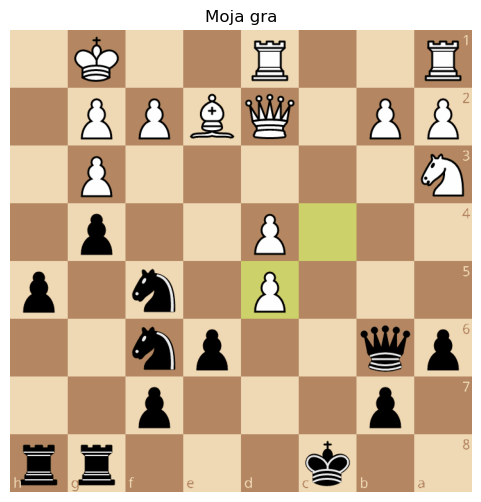

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def show_img(img, title="Obraz"):

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

game_img = cv2.imread('assets/sample/my_game.png')

if game_img is not None:
    print(f"Wymiary obrazka: {game_img.shape}") # (wysokość, szerokość, kanały)
    show_img(game_img, "Moja gra")
else:
    print("Nie znaleziono pliku!")

# **Krok 2: Segmentacja obrazu planszy (Grid Slicing) i ekstrakcja pól.**

Dekompozycja jednolitego obrazu całej planszy (macierzy 720x720 pikseli) na zbiór 64 niezależnych podobrazów o wymiarach 90x90 pikseli. Wykorzystując iteracyjne pętle, wyznaczamy współrzędne graniczne dla każdego pola szachowego i wycinamy odpowiadające im fragmenty.

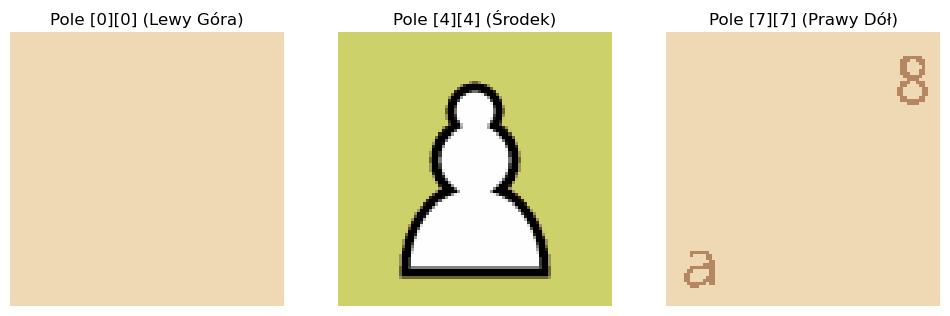

In [3]:
SQUARE_SIZE = 90

squares = []

# Tnięcie obrazu 
for row in range(8):
    row_squares = []
    for col in range(8):

        y_start = row * SQUARE_SIZE
        y_end = y_start + SQUARE_SIZE
        x_start = col * SQUARE_SIZE
        x_end = x_start + SQUARE_SIZE
        
        square = game_img[y_start:y_end, x_start:x_end]
        row_squares.append(square)
    squares.append(row_squares)

# --- SPRAWDZENIE WYNIKÓW ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Lewy górny róg (Puste pole)
axs[0].imshow(cv2.cvtColor(squares[0][0], cv2.COLOR_BGR2RGB))
axs[0].set_title("Pole [0][0] (Lewy Góra)")
axs[0].axis('off')

# Środek planszy (jakieś losowe pole)
axs[1].imshow(cv2.cvtColor(squares[4][4], cv2.COLOR_BGR2RGB))
axs[1].set_title("Pole [4][4] (Środek)")
axs[1].axis('off')

# Prawy dolny róg
axs[2].imshow(cv2.cvtColor(squares[7][7], cv2.COLOR_BGR2RGB))
axs[2].set_title("Pole [7][7] (Prawy Dół)")
axs[2].axis('off')

plt.show()

# **Krok 3: Detekcja, klasyfikacja obiektów i wizualizacja wyników.**
Algorytm przetwarza macierz 8x8 pól w pętli, stosując hybrydowe podejście do klasyfikacji: wstępną analizę statystyczną (wariancja) do odróżnienia pól pustych od zajętych, a następnie dopasowanie wzorców (Template Matching) przy użyciu normy różnicowej TM_SQDIFF_NORMED. Dodatkowo zaimplementowano heurystyczną logikę ratunkową (fallback logic) dla obiektów o niskim kontraście (głównie czarnych pionków).

✅ Wczytano obraz: my_game.png
Rozpoczynam analizę planszy...
✅ Analiza zakończona pomyślnie.


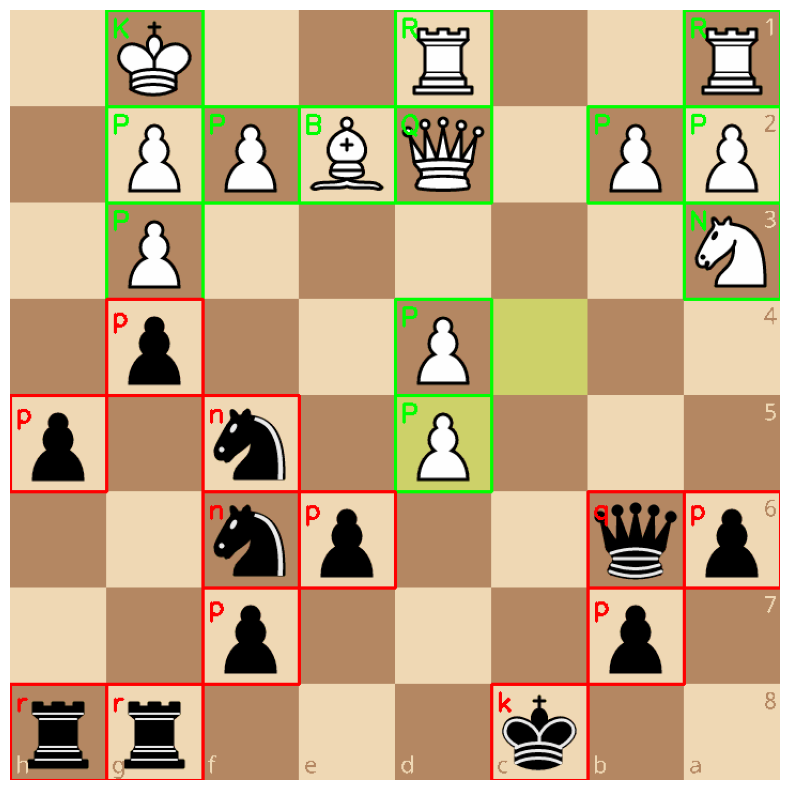

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

NAZWA_PLIKU = 'my_game.png' 
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# WCZYTANIE WZORCÓW
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue
    
    # Tworzenie twardej maski (dla lepszej detekcji krawędzi)
    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

# WCZYTANIE OBRAZU 
full_path = os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU)
game_img = cv2.imread(full_path)

if game_img is None:
    print(f"❌ BŁĄD: Nie znaleziono pliku: {full_path}")
else:
    print(f"✅ Wczytano obraz: {NAZWA_PLIKU}")

    # Cięcie na 64 pola
    squares = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            y, x = row * 90, col * 90
            square = game_img[y:y+90, x:x+90]
            row_squares.append(square)
        squares.append(row_squares)

    # FUNKCJE POMOCNICZE
    def is_square_empty(square_img, variance_threshold=20):
        """Sprawdza czy pole jest puste na podstawie odchylenia standardowego kolorów."""
        gray = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
        std_dev = np.std(gray)
        return std_dev < variance_threshold

    def identify_piece(square_img, threshold=0.60):
        """Rozpoznaje figurę metodą Template Matching (SQDIFF)."""
        best_confidence = -1.0
        best_symbol = None
        
        for symbol, data in templates.items():
            res = cv2.matchTemplate(square_img, data['img'], cv2.TM_SQDIFF_NORMED, mask=data['mask'])
            min_diff, _, _, _ = cv2.minMaxLoc(res)
            confidence = 1.0 - min_diff
            
            if confidence > best_confidence:
                best_confidence = confidence
                best_symbol = symbol
                
        if best_confidence < threshold:
            return None, best_confidence
        
        return best_symbol, best_confidence

    # ANALIZA PLANSZY 
    output_img = game_img.copy()
    board_str = [] 

    print("Rozpoczynam analizę planszy...")

    for row in range(8):
        row_str = []
        for col in range(8):
            square = squares[row][col]
            y, x = row * 90, col * 90
            
            if is_square_empty(square, variance_threshold=20):
                row_str.append('.')
                continue 
            
            piece, score = identify_piece(square, threshold=0.60)
            
            if piece is None:
                # Jeśli pole nie jest puste, a figura nie została rozpoznana,
                # sprawdzamy czy to czarny pion z obniżonym progiem
                pawn_data = templates['p']
                res = cv2.matchTemplate(square, pawn_data['img'], cv2.TM_SQDIFF_NORMED, mask=pawn_data['mask'])
                min_diff, _, _, _ = cv2.minMaxLoc(res)
                pawn_confidence = 1.0 - min_diff
                
                if pawn_confidence > 0.45:
                    piece = 'p'
                else:
                    piece = 'p' 

            if piece:
                row_str.append(piece)
                color = (0, 255, 0) if piece.isupper() else (0, 0, 255)
                
                cv2.rectangle(output_img, (x, y), (x+90, y+90), color, 2)
                cv2.putText(output_img, piece, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        board_str.append(row_str)

    print("✅ Analiza zakończona pomyślnie.")


    img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# **Krok 4. Generowanie kodu FEM.**

In [5]:
def generate_fen(board_grid):

    fen_parts = []
    
    for row in board_grid:
        empty_count = 0
        line = ""
        
        for char in row:
            if char == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    line += str(empty_count)
                    empty_count = 0
                line += char
        
        if empty_count > 0:
            line += str(empty_count)
            
        fen_parts.append(line)
        
    return "/".join(fen_parts) + " w KQkq - 0 1"

# --- UŻYCIE ---
if 'board_str' in locals():
    final_fen = generate_fen(board_str)
    
    print("\nKod FEN:")
    print(final_fen)
    print("-" * 30)
    print("Możesz go wkleić tutaj: https://lichess.org/analysis")
else:
    print("Najpierw uruchom analizę obrazka!")


Kod FEN:
1K2R2R/1PPBQ1PP/1P5N/1p2P3/p1n1P3/2np2qp/2p3p1/rr3k2 w KQkq - 0 1
------------------------------
Możesz go wkleić tutaj: https://lichess.org/analysis


# **UPLEPSZENIA**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Stałe
BOARD_SIZE = 720
SQUARE_SIZE = 90
EMPTY_THRESHOLD = 20  

def show_img(img, title="Obraz"):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Biblioteki załadowane.")

Biblioteki załadowane.


In [17]:
def load_all_themes(base_path='assets/pieces'):
    """
    Ładuje wszystkie obrazy figur ze wszystkich podfolderów.
    Zwraca słownik: templates[nazwa_pliku_bez_rozszerzenia] = obraz
    Np. jeśli masz plik 'assets/pieces/alpha/wP.png', kluczem będzie 'wP' (lub unikalne ID).
    Dla uproszczenia zakładamy, że pliki nazywają się standardowo: wP.png, bN.png itd.
    """
    templates = []
    
    files = glob.glob(os.path.join(base_path, '**', '*.png'), recursive=True)
    
    if not files:
        print(f"UWAGA: Nie znaleziono żadnych plików w {base_path}. Sprawdź ścieżkę!")
        return []

    print(f"Znaleziono {len(files)} plików z figurami. Trwa ładowanie...")
    
    for f in files:
        img = cv2.imread(f) 
        if img is None: continue
        
        img = cv2.resize(img, (SQUARE_SIZE, SQUARE_SIZE))
        
        filename = os.path.basename(f)
        piece_code = os.path.splitext(filename)[0] 
        
        templates.append({
            'code': piece_code, 
            'image': img,
            'source': f
        })
        
    print(f"Załadowano {len(templates)} szablonów figur.")
    return templates

all_piece_templates = load_all_themes('assets/pieces')

Znaleziono 464 plików z figurami. Trwa ładowanie...
Załadowano 464 szablonów figur.


In [18]:
import os
import glob

def find_bad_filenames(base_path='assets/pieces'):
    print(f"🔍 Przeszukuję folder: {base_path} w poszukiwaniu błędnych nazw...")
    
    files = glob.glob(os.path.join(base_path, '**', '*.png'), recursive=True)
    
    found_problems = False
    
    for f in files:
        filename = os.path.basename(f)          
        piece_code = os.path.splitext(filename)[0] 
        
        if len(piece_code) < 2:
            found_problems = True
            print(f"❌ ZNALEZIONO BŁĄD: {f}")
            print(f"   -> Nazwa pliku '{filename}' daje kod '{piece_code}' (za krótki!)")
            print(f"   -> Oczekiwana nazwa np.: 'wP.png', 'bK.png'\n")

    if not found_problems:
        print("✅ Wszystkie pliki PNG mają poprawne nazwy (min. 2 znaki).")
    else:
        print("❗ Napraw powyższe pliki (zmień nazwę lub usuń), aby program działał.")

find_bad_filenames()

🔍 Przeszukuję folder: assets/pieces w poszukiwaniu błędnych nazw...
❌ ZNALEZIONO BŁĄD: assets/pieces\disguised\pngs\b.png
   -> Nazwa pliku 'b.png' daje kod 'b' (za krótki!)
   -> Oczekiwana nazwa np.: 'wP.png', 'bK.png'

❌ ZNALEZIONO BŁĄD: assets/pieces\disguised\pngs\w.png
   -> Nazwa pliku 'w.png' daje kod 'w' (za krótki!)
   -> Oczekiwana nazwa np.: 'wP.png', 'bK.png'

❌ ZNALEZIONO BŁĄD: assets/pieces\mono\pngs\B.png
   -> Nazwa pliku 'B.png' daje kod 'B' (za krótki!)
   -> Oczekiwana nazwa np.: 'wP.png', 'bK.png'

❌ ZNALEZIONO BŁĄD: assets/pieces\mono\pngs\K.png
   -> Nazwa pliku 'K.png' daje kod 'K' (za krótki!)
   -> Oczekiwana nazwa np.: 'wP.png', 'bK.png'

❌ ZNALEZIONO BŁĄD: assets/pieces\mono\pngs\N.png
   -> Nazwa pliku 'N.png' daje kod 'N' (za krótki!)
   -> Oczekiwana nazwa np.: 'wP.png', 'bK.png'

❌ ZNALEZIONO BŁĄD: assets/pieces\mono\pngs\P.png
   -> Nazwa pliku 'P.png' daje kod 'P' (za krótki!)
   -> Oczekiwana nazwa np.: 'wP.png', 'bK.png'

❌ ZNALEZIONO BŁĄD: assets/pi

In [3]:
def preprocess_board(image_path):
    """Wczytuje i skaluje planszę do 720x720."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Nie można wczytać obrazu.")
    
    if img.shape[0] != BOARD_SIZE or img.shape[1] != BOARD_SIZE:
        print(f"Skalowanie obrazu z {img.shape} do ({BOARD_SIZE}, {BOARD_SIZE})")
        img = cv2.resize(img, (BOARD_SIZE, BOARD_SIZE))
    
    return img

def is_square_empty(square_img, threshold=EMPTY_THRESHOLD):
    gray = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
    # Oblicz średnią i odchylenie standardowe
    mean, std_dev = cv2.meanStdDev(gray)
    
    return std_dev[0][0] < threshold

def identify_piece(square_img, templates):
    best_score = -1
    best_piece = None
    
    for tmpl in templates:
        res = cv2.matchTemplate(square_img, tmpl['image'], cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(res)
        
        if max_val > best_score:
            best_score = max_val
            best_piece = tmpl['code']
            
    return best_piece, best_score

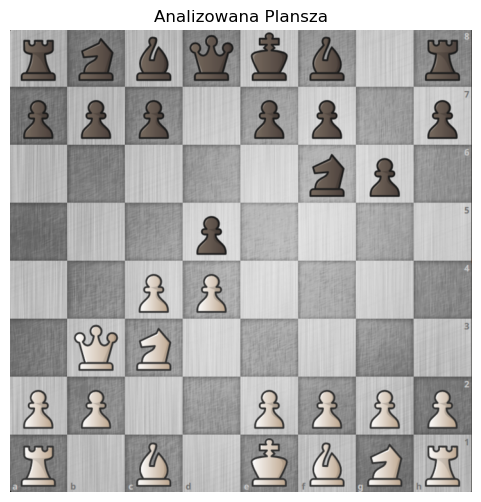

Rozpoczynam analizę pól...

Wygenerowany FEN: rnbqkb1r/ppp1pp1p/5np1/3p4/2PP4/1QN5/PP2PPPP/P1B1KBQR


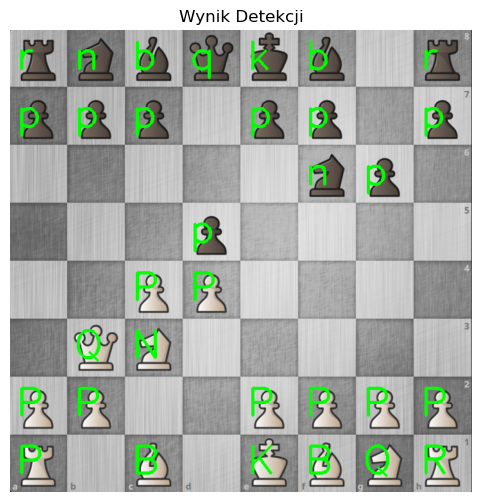

In [23]:
def analyze_chess_board(image_path, templates):
    board_img = preprocess_board(image_path)
    show_img(board_img, "Analizowana Plansza")
    
    fen_rows = []
    
    debug_img = board_img.copy()
    
    print("Rozpoczynam analizę pól...")
    
    for row in range(8):
        empty_count = 0
        fen_row_str = ""
        
        for col in range(8):
            y_start, y_end = row * SQUARE_SIZE, (row + 1) * SQUARE_SIZE
            x_start, x_end = col * SQUARE_SIZE, (col + 1) * SQUARE_SIZE
            square = board_img[y_start:y_end, x_start:x_end]
            
            if is_square_empty(square):
                empty_count += 1
            else:
            
                if empty_count > 0:
                    fen_row_str += str(empty_count)
                    empty_count = 0
                
                piece_code, score = identify_piece(square, templates)
                
                if score < 0.3: 
                    empty_count += 1
                else:
                    color = piece_code[0] # 'w' lub 'b'
                    role = piece_code[1]  # 'P', 'N', 'B', 'R', 'Q', 'K'
                    fen_char = role.upper() if color == 'w' else role.lower()
                    
                    fen_row_str += fen_char
                    
                    cv2.putText(debug_img, fen_char, (x_start + 10, y_start + 60), 
                                cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

        if empty_count > 0:
            fen_row_str += str(empty_count)
        
        fen_rows.append(fen_row_str)

    final_fen = "/".join(fen_rows)
    print(f"\nWygenerowany FEN: {final_fen}")
    
    show_img(debug_img, "Wynik Detekcji")
    return final_fen

target_image = 'assets/sample/my_game5.png' 

if len(all_piece_templates) > 0:
    fen = analyze_chess_board(target_image, all_piece_templates)
else:
    print("Najpierw załaduj szablony figur w Bloku 2!")

🕵️ Rozpoznawanie stylu graficznego figur...
✅ Wykryto styl: 'pngs' (Liczba głosów: 17)
   -> Odrzucam figury z innych stylów, aby uniknąć pomyłek (np. N vs Q).


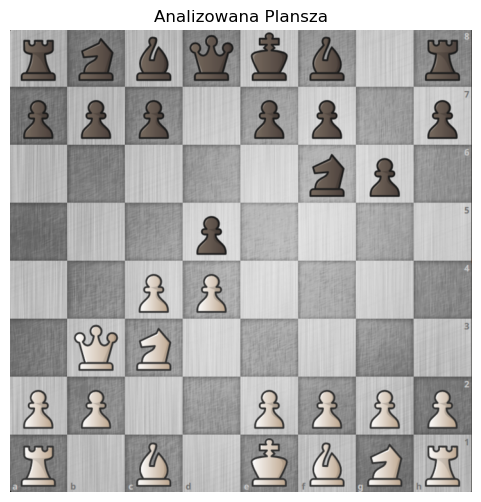

Rozpoczynam precyzyjną analizę pól...

Wygenerowany FEN: rnbqkb1r/ppp1pp1p/5np1/3p31/2PP4/1QN5/PP2PPPP/P1B1KBQR


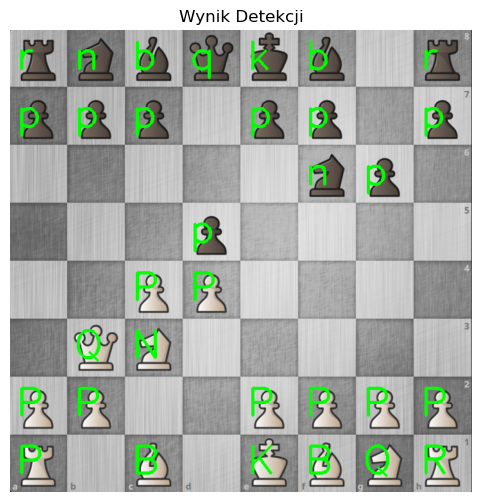

In [24]:
# --- FUNKCJE POMOCNICZE DO MOTYWÓW ---
def get_theme_from_path(path):
    """
    Wyciąga nazwę folderu z motywem ze ścieżki pliku.
    Np. 'assets/pieces/alpha/wP.png' -> 'alpha'
    """
    return os.path.basename(os.path.dirname(path))

def detect_and_solve(image_path, all_templates):
    board_img = preprocess_board(image_path)
    
    # 1. FAZA DETEKCJI MOTYWU (Voting)
    print("🕵️ Rozpoznawanie stylu graficznego figur...")
    theme_votes = {}
    
    # Skanujemy tylko rzędy 0, 1, 6, 7 (tam gdzie na pewno są figury na starcie)
    # żeby szybciej ustalić styl
    rows_to_check = [0, 1, 6, 7] 
    
    for row in rows_to_check:
        for col in range(8):
            y_start, y_end = row * SQUARE_SIZE, (row + 1) * SQUARE_SIZE
            x_start, x_end = col * SQUARE_SIZE, (col + 1) * SQUARE_SIZE
            square = board_img[y_start:y_end, x_start:x_end]
            
            # Jeśli pole nie jest puste (używamy Twojej logiki lub std_dev)
            if not is_square_empty(square, threshold=15): # próg 15 dla bezpieczeństwa
                # Szukamy najlepiej pasującego szablonu
                best_score = -1
                best_tmpl = None
                
                for tmpl in all_templates:
                    res = cv2.matchTemplate(square, tmpl['image'], cv2.TM_CCOEFF_NORMED)
                    _, max_val, _, _ = cv2.minMaxLoc(res)
                    if max_val > best_score:
                        best_score = max_val
                        best_tmpl = tmpl
                
                # Jeśli dopasowanie jest mocne, oddajemy głos na ten motyw
                if best_score > 0.65:
                    theme_name = get_theme_from_path(best_tmpl['source'])
                    theme_votes[theme_name] = theme_votes.get(theme_name, 0) + 1

    # Wybór zwycięskiego motywu
    if not theme_votes:
        print("⚠️ Nie udało się wykryć stylu (brak figur?). Używam wszystkich szablonów.")
        final_templates = all_templates
    else:
        best_theme = max(theme_votes, key=theme_votes.get)
        print(f"✅ Wykryto styl: '{best_theme}' (Liczba głosów: {theme_votes[best_theme]})")
        print(f"   -> Odrzucam figury z innych stylów, aby uniknąć pomyłek (np. N vs Q).")
        
        # Filtrujemy listę - zostawiamy tylko ten jeden styl
        final_templates = [t for t in all_templates if get_theme_from_path(t['source']) == best_theme]

    # 2. FAZA GŁÓWNA - Twoja funkcja analysis (z drobnymi poprawkami)
    # Wywołujemy ją już tylko z przefiltrowanymi szablonami
    return run_final_analysis(board_img, final_templates)


def run_final_analysis(board_img, templates):
    show_img(board_img, "Analizowana Plansza")
    debug_img = board_img.copy()
    fen_rows = []
    
    print("Rozpoczynam precyzyjną analizę pól...")
    
    for row in range(8):
        empty_count = 0
        fen_row_str = ""
        
        for col in range(8):
            y_start, y_end = row * SQUARE_SIZE, (row + 1) * SQUARE_SIZE
            x_start, x_end = col * SQUARE_SIZE, (col + 1) * SQUARE_SIZE
            square = board_img[y_start:y_end, x_start:x_end]
            
            # Używamy Twojego is_square_empty (lub ulepszonej wersji na std_dev)
            if is_square_empty(square, threshold=15): # Lekko obniżony próg dla pewności
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row_str += str(empty_count)
                    empty_count = 0
                
                # Teraz szukamy figury TYLKO w wybranym motywie
                piece_code, score = identify_piece(square, templates)
                
                if score < 0.35: # Lekko podniesiony próg minimalny
                    empty_count += 1
                else:
                    color = piece_code[0]
                    role = piece_code[1]
                    fen_char = role.upper() if color == 'w' else role.lower()
                    
                    fen_row_str += fen_char
                    
                    # Rysujemy wynik
                    cv2.putText(debug_img, fen_char, (x_start + 10, y_start + 60), 
                                cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

        if empty_count > 0:
            fen_row_str += str(empty_count)
        fen_rows.append(fen_row_str)

    final_fen = "/".join(fen_rows)
    print(f"\nWygenerowany FEN: {final_fen}")
    show_img(debug_img, "Wynik Detekcji")
    return final_fen

# --- URUCHOMIENIE ---
target_image = 'assets/sample/my_game5.png' 

if len(all_piece_templates) > 0:
    # Używamy nowej, mądrzejszej funkcji
    fen = detect_and_solve(target_image, all_piece_templates)
else:
    print("Najpierw załaduj szablony figur w Bloku 2!")

# **TESTOWANIE INNYCH OBRAZKÓW** 

✅ Wczytano obraz: starting_board.png ((720, 720, 3))
Rozpoczynam analizę...

KOD FEN :
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


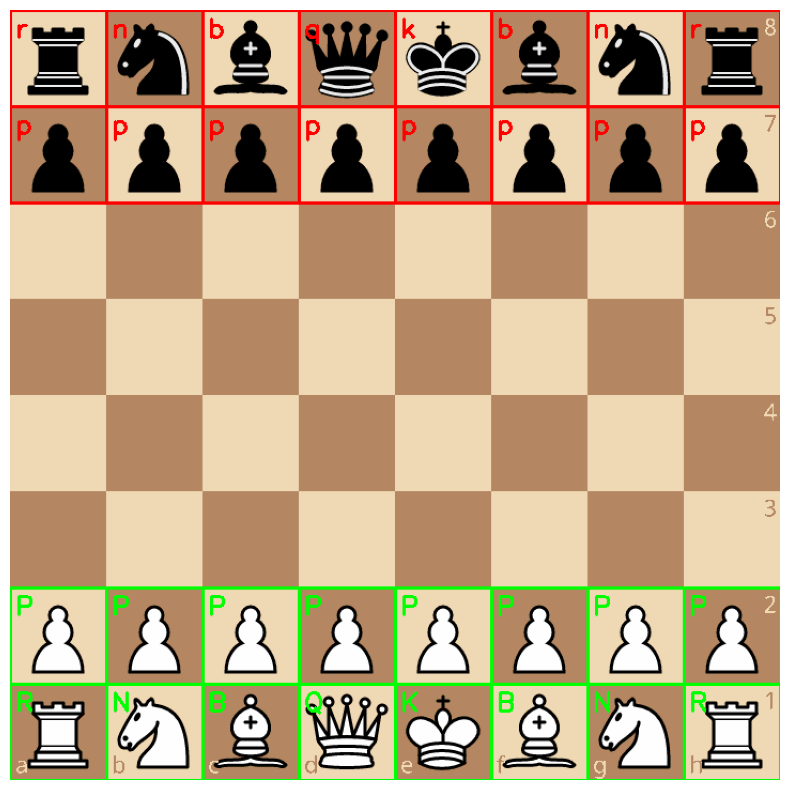

In [65]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

NAZWA_PLIKU = 'starting_board.png' 
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# WCZYTANIE WZORCÓW
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue

    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

# WCZYTANIE OBRAZU GRY 
full_path = os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU)
game_img = cv2.imread(full_path)

if game_img is None:
    print(f"❌ BŁĄD: Nie znaleziono pliku: {full_path}")
else:
    print(f"✅ Wczytano obraz: {NAZWA_PLIKU} ({game_img.shape})")

    squares = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            y, x = row * 90, col * 90
            square = game_img[y:y+90, x:x+90]
            row_squares.append(square)
        squares.append(row_squares)

    # ANALIZA PLANSZY
    output_img = game_img.copy()
    board_str = []
    
    print("Rozpoczynam analizę...")

    for row in range(8):
        row_str = []
        for col in range(8):
            square = squares[row][col]
            y, x = row * 90, col * 90
            
            gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
            if np.std(gray) < 20:
                row_str.append('.')
                continue 
            
            best_confidence = -1.0
            best_symbol = None
            for symbol, data in templates.items():
                res = cv2.matchTemplate(square, data['img'], cv2.TM_SQDIFF_NORMED, mask=data['mask'])
                min_diff, _, _, _ = cv2.minMaxLoc(res)
                confidence = 1.0 - min_diff
                if confidence > best_confidence:
                    best_confidence = confidence
                    best_symbol = symbol
            
            piece = best_symbol if best_confidence >= 0.60 else None

            if piece is None:
                piece = 'p'

            if piece:
                row_str.append(piece)
                color = (0, 255, 0) if piece.isupper() else (0, 0, 255)
                cv2.rectangle(output_img, (x, y), (x+90, y+90), color, 2)
                cv2.putText(output_img, piece, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        board_str.append(row_str)

    # FEM
    def get_fen(grid):
        fen_parts = []
        for row in grid:
            empty = 0
            line = ""
            for char in row:
                if char == '.': empty += 1
                else:
                    if empty > 0: line += str(empty); empty = 0
                    line += char
            if empty > 0: line += str(empty)
            fen_parts.append(line)
        return "/".join(fen_parts) + " w KQkq - 0 1"

    fen_result = get_fen(board_str)


    print("\nKOD FEN :")
    print(f"{fen_result}")


    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# **ANALIZA BLĘDÓW**

### **Analiza porównawcza metod dopasowywania wzorców (Template Matching)**

W ramach projektu przetestowano różne metody matematyczne dostępne w bibliotece OpenCV w celu wyłonienia najskuteczniejszego algorytmu detekcji figur. Poniższa analiza wyjaśnia przyczyny niepowodzenia metod opartych na korelacji oraz sukces metody różnicowej

#### **TM_CCOEFF_NORMED (Obraz po lewej)**
Metoda znormalizowanego współczynnika korelacji (Correlation Coefficient) bada, jak bardzo jasność pikseli na obrazie zmienia się w zgodzie z jasnością pikseli we wzorcu, odejmując przy tym średnią jasność (kompensacja oświetlenia).

**Co widzimy na obrazku?** 
- Białe figury (Dół): Wykryte poprawnie (zielone ramki).
- Czarne duże figury (Góra): Wykryte częściowo poprawnie (czerwone ramki), choć z niższą pewnością.
- Czarne pionki (Rząd 7): Całkowity brak detekcji. Algorytm pominął wszystkie czarne pionki, traktując je jako puste pola.

**Dlaczego nie zadziałało?**
Problem wynika ze zbyt niskiego kontrastu lokalnego. Czarny pionek składa się z ciemnych pikseli i znajduje się na relatywnie ciemnym polu. Matematycznie, wariancja (zmienność) sygnału w tym obszarze jest minimalna. Metoda CCOEFF nie była w stanie odróżnić "ciemnego kształtu piona" od "ciemnego tła pola" z wystarczającą pewnością (wynik dopasowania spadał poniżej progu 0.60, co skutkowało odrzuceniem detekcji – tzw. błąd False Negative).

#### **TM_CCORR_NORMED (Obraz po prawej)**
Metoda korelacji wzajemnej (Cross Correlation) opiera się na iloczynie skalarnym wektorów pikseli. Mnoży ona wartość piksela obrazu przez wartość piksela wzorca.

**Co widać na obrazku**
- Niestabilność: Algorytm generuje detekcje na prawie każdym polu (niebieskie ramki wszędzie).
- Wysokie wyniki na pustych polach: Puste, jasne pola otrzymują wysokie oceny dopasowania (np. 0.8), mimo że nie ma tam figury.
- Przyczyna porażki (Dlaczego nie zadziałało?): Ta metoda jest bardzo wrażliwa na jasność, a nie na kształt.

**Problem czerni:** Czarne piksele mają wartość bliską 0. W matematyce 0×cokolwiek=0. Detekcja czarnych figur na czarnym tle prowadzi do błędów numerycznych i bardzo niskich wyników korelacji.

**Problem bieli:** Puste, jasne pola mają wysokie wartości pikseli (np. 200-255). Mnożenie ich przez jasne piksele wzorca daje ogromne wyniki, co algorytm błędnie interpretuje jako "świetne dopasowanie" (błąd False Positive).

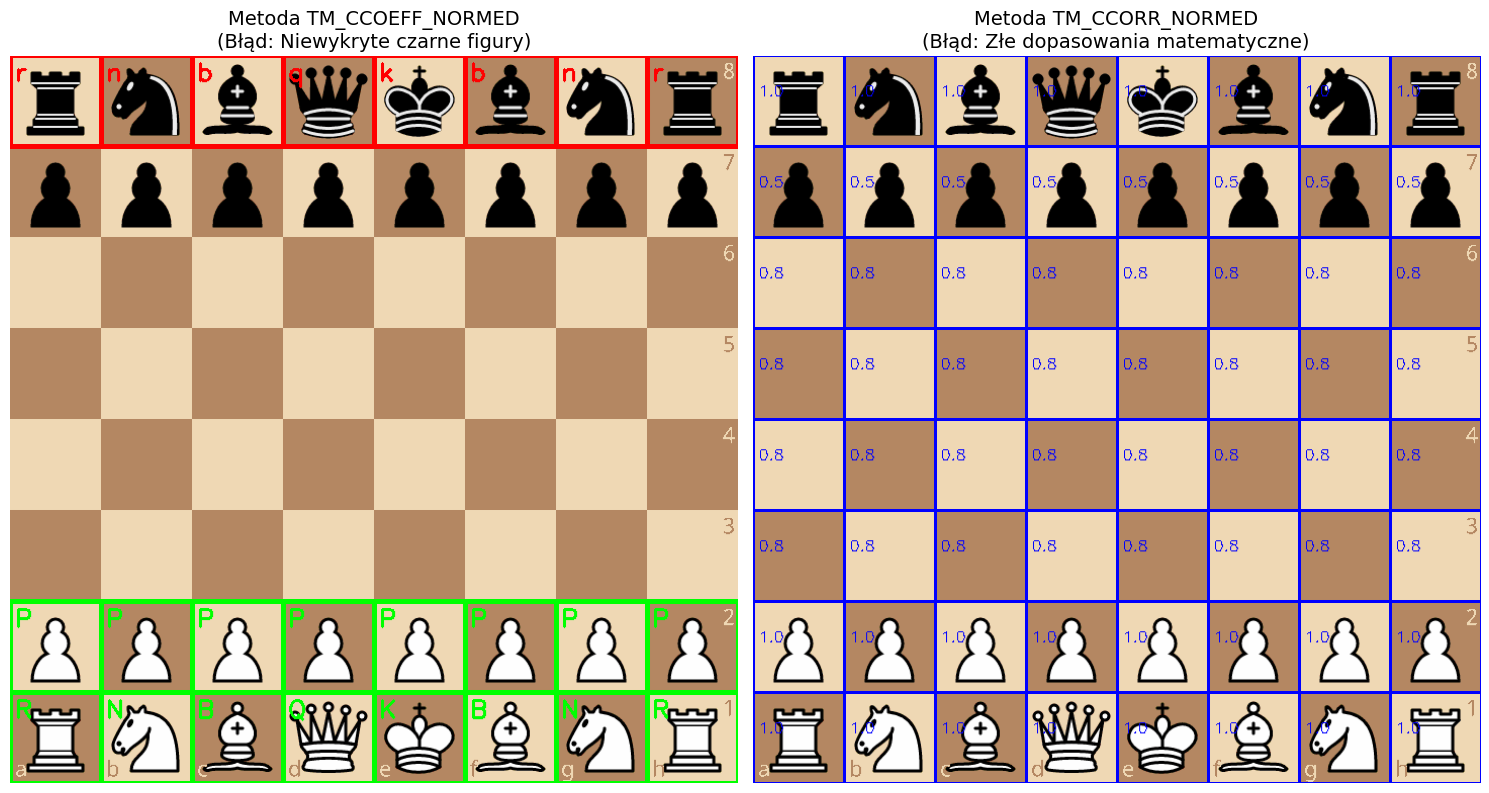

In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. KONFIGURACJA
NAZWA_PLIKU = 'starting_board.png'
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# 2. WCZYTANIE DANYCH
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue
    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

game_img = cv2.imread(os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU))
squares = []
for row in range(8):
    for col in range(8):
        y, x = row * 90, col * 90
        squares.append((game_img[y:y+90, x:x+90], x, y))

# 3. GENEROWANIE WIZUALIZACJI BŁĘDÓW
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# --- METODA 1: CCOEFF (Problem kontrastu) ---
img_ccoeff = game_img.copy()
for square, x, y in squares:
    best_score = -1
    best_sym = None
    for sym, data in templates.items():
        res = cv2.matchTemplate(square, data['img'], cv2.TM_CCOEFF_NORMED, mask=data['mask'])
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_sym = sym
    
    # Próg 0.80 wykrywa białe, ale gubi czarne
    if best_score > 0.80:
        color = (0, 255, 0) if best_sym.isupper() else (0, 0, 255)
        cv2.rectangle(img_ccoeff, (x, y), (x+90, y+90), color, 3)
        cv2.putText(img_ccoeff, best_sym, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

ax[0].imshow(cv2.cvtColor(img_ccoeff, cv2.COLOR_BGR2RGB))
ax[0].set_title("Metoda TM_CCOEFF_NORMED\n(Błąd: Niewykryte czarne figury)", fontsize=14)
ax[0].axis('off')

# --- METODA 2: CCORR (Błąd matematyczny) ---
img_ccorr = game_img.copy()
for square, x, y in squares:
    best_score = 0
    best_sym = None
    for sym, data in templates.items():
        res = cv2.matchTemplate(square, data['img'], cv2.TM_CCORR_NORMED, mask=data['mask'])
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_sym = sym
            
    # CCORR często zwraca błędy na czarnych polach lub dopasowuje cokolwiek
    # Rysujemy wszystko co znajdzie, żeby pokazać chaos
    if best_sym:
        cv2.rectangle(img_ccorr, (x, y), (x+90, y+90), (255, 0, 0), 2)
        # Wypisujemy wynik, często są to dziwne liczby
        cv2.putText(img_ccorr, f"{best_score:.1f}", (x+5, y+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

ax[1].imshow(cv2.cvtColor(img_ccorr, cv2.COLOR_BGR2RGB))
ax[1].set_title("Metoda TM_CCORR_NORMED\n(Błąd: Złe dopasowania matematyczne)", fontsize=14)
ax[1].axis('off')

plt.tight_layout()
plt.show()

--- Diagnostyka (Pierwsze 3 błędy) ---
Pole a8: Wykryto 'N' z pewnością 0.12 (Próg: 0.7)
Pole b8: Wykryto 'n' z pewnością 0.38 (Próg: 0.7)
Pole c8: Wykryto 'b' z pewnością 0.14 (Próg: 0.7)
Pole d8: Wykryto 'q' z pewnością 0.55 (Próg: 0.7)
Pole e8: Wykryto 'k' z pewnością 0.67 (Próg: 0.7)
Pole f8: Wykryto 'b' z pewnością 0.57 (Próg: 0.7)
Pole g8: Wykryto 'n' z pewnością 0.62 (Próg: 0.7)
Pole h8: Wykryto 'r' z pewnością 0.69 (Próg: 0.7)
Pole a7: Wykryto 'p' z pewnością 0.47 (Próg: 0.7)
Pole b7: Wykryto 'N' z pewnością 0.47 (Próg: 0.7)
Pole f7: Wykryto 'p' z pewnością 0.45 (Próg: 0.7)
Pole g7: Wykryto 'p' z pewnością 0.65 (Próg: 0.7)
Pole h7: Wykryto 'p' z pewnością 0.57 (Próg: 0.7)
Pole e6: Wykryto 'p' z pewnością 0.50 (Próg: 0.7)
Pole c5: Wykryto 'p' z pewnością 0.63 (Próg: 0.7)
Pole d5: Wykryto 'p' z pewnością 0.47 (Próg: 0.7)
Pole c4: Wykryto 'P' z pewnością 0.72 (Próg: 0.7)
Pole a2: Wykryto 'N' z pewnością 0.63 (Próg: 0.7)
Pole b2: Wykryto 'P' z pewnością 0.68 (Próg: 0.7)
Pole e2: Wykryto 'P' z pewnością 0.73 (Próg: 0.7)
Pole a1: Wykryto 'B' z pewnością 0.68 (Próg: 0.7)
Pole c1: Wykryto 'B' z pewnością 0.75 (Próg: 0.7)
Pole d1: Wykryto 'Q' z pewnością 0.64 (Próg: 0.7)
Pole e1: Wykryto 'K' z pewnością 0.75 (Próg: 0.7)

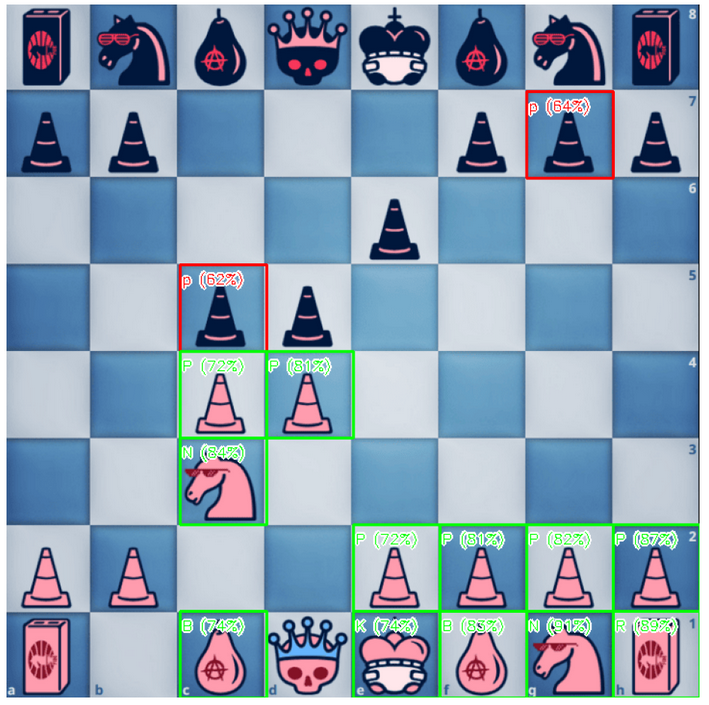
